# Making the Most of your Colab Subscription



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Path to the dataset
dataset_dir = '/content/drive/MyDrive/Soil Nitrogen Levels'

# Create lists to hold image paths and labels
image_paths = []
labels = []

# Walk through each class directory
for label in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(label)

# Convert the data into a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Split the dataset (80% train, 10% validation, 10% test)
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Display the shapes of training, validation, and testing sets
print(f"Training set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Testing set: {test_data.shape}")


Training set: (608, 2)
Validation set: (76, 2)
Testing set: (76, 2)


In [ ]:
# Split the dataset (80% for training, 10% for validation, 10% for testing)
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Save the split dataset to CSV files (optional)
train_data.to_csv('/content/drive/MyDrive/mareertrain_datares_80.csv', index=False)
val_data.to_csv('/content/drive/MyDrive/mareerval_datares_10.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/mareertest_datares_10.csv', index=False)

# Display the shapes of training, validation, and testing sets
print(f"Training set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Testing set: {test_data.shape}")


Training set: (608, 2)
Validation set: (76, 2)
Testing set: (76, 2)


In [ ]:
# Create an ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load validation data from DataFrame
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load testing data from DataFrame
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 608 validated image filenames belonging to 4 classes.
Found 76 validated image filenames belonging to 4 classes.
Found 76 validated image filenames belonging to 4 classes.


In [ ]:
# Load the ResNet50 model, excluding the top fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base of ResNet50 to prevent training initially
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Add custom layers on top of the ResNet-50 base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer with softmax activation for multi-class classification
num_classes = len(train_generator.class_indices)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,279,108 (187.98 MB)

 Trainable params: 25,691,396 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/mareerbest_resnet_model.keras', monitor='val_loss', save_best_only=True)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Adjust as needed
    callbacks=[early_stopping, model_checkpoint]
)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Extract the training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 192s 7s/step - accuracy: 0.2446 - loss: 2.9374 - val_accuracy: 0.4375 - val_loss: 1.2727
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.4214
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.3299 - loss: 1.4026 - val_accuracy: 0.4062 - val_loss: 1.2598
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.2953
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.3192 - loss: 1.3463 - val_accuracy: 0.3906 - val_loss: 1.2755
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 1.2713
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.3885 - loss: 1.2954 - val_accuracy: 0.3281 - val_loss: 1.3038
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1667 - val_loss: 1.2904
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.4271 - loss: 1.2736
Test Loss: 1.2702

In [ ]:
# Unfreeze the last few layers of ResNet-50 for fine-tuning
# Let's unfreeze the last 20 layers of ResNet-50
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate to avoid overfitting during fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test generator
true_labels = test_generator.classes

# Predict the probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the class labels (for use in confusion matrix)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.2604 - loss: 1.3054
Test Loss: 1.3060758113861084, Test Accuracy: 0.25


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


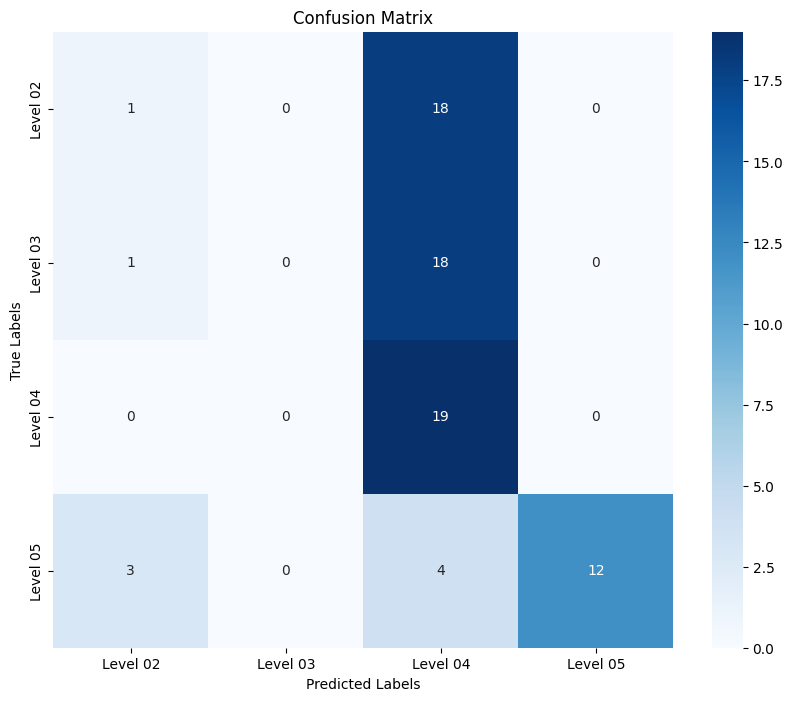

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test generator
true_labels = test_generator.classes

# Predict the probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the class labels (for use in confusion matrix)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step


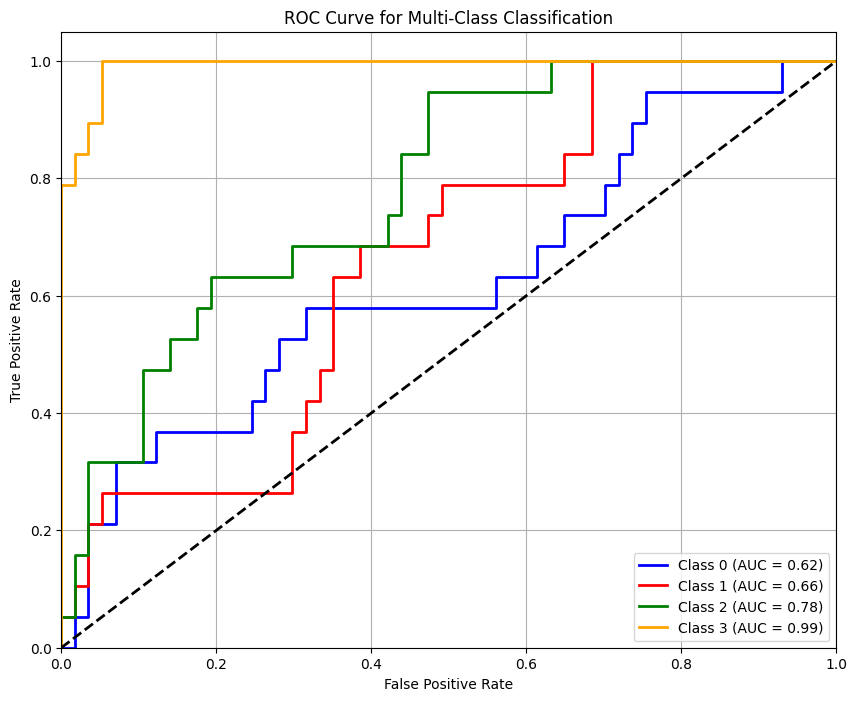

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get true labels and predict probabilities
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Binarize the true labels for multi-class classification (one-vs-rest)
n_classes = len(test_generator.class_indices)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()  # AUC for each class

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Get true labels from test generator
true_labels = test_generator.classes

# Predict probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

# Display the classification report
print(report)

# Calculate the macro and weighted F1-scores
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the macro and weighted F1-scores
print(f"Macro F1-Score: {macro_f1}")
print(f"Weighted F1-Score: {weighted_f1}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
              precision    recall  f1-score   support

    Level 02       0.20      0.05      0.08        19
    Level 03       0.00      0.00      0.00        19
    Level 04       0.32      1.00      0.49        19
    Level 05       1.00      0.63      0.77        19

    accuracy                           0.42        76
   macro avg       0.38      0.42      0.34        76
weighted avg       0.38      0.42      0.34        76

Macro F1-Score: 0.3361765922249793
Weighted F1-Score: 0.3361765922249793


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save the trained model in the .keras format (recommended for new Keras versions)
model.save('/content/drive/MyDrive/resfinal_trained_model.keras')
